In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn.functional as F
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

torch.set_default_dtype(torch.float64)
# torch.set_default_tensor_type('torch.FloatTensor')
# torch.set_default_device('cuda:0')
torch.set_default_device('cpu')


torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0)

(True,
 1,
 0,
 'NVIDIA RTX A5000 Laptop GPU')

In [2]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params   
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u

In [3]:
def fourier_shift(u: torch.Tensor, eps: float=0., dim: int=-1, order: int=0) -> torch.Tensor:
    """
    Shift in Fourier space.
    Args:
        u (torch.Tensor): input tensor, usually of shape [batch, t, x]
        eps (float): shift parameter
        dim (int): dimension which is used for shifting
        order (int): derivative order
    Returns:
        torch.Tensor: Fourier shifted input
    """
    assert dim < 0
    n = u.shape[dim]
    u_hat = torch.fft.rfft(u, dim=dim, norm='ortho')
    # Fourier modes
    omega = torch.arange(n // 2 + 1)
    if n % 2 == 0:
        omega[-1] *= 0
    # Applying Fourier shift according to shift theorem
    fs = torch.exp(- 2 * np.pi * 1j * omega * eps)
    # For order>0 derivative is taken
    fs = (- 2 * np.pi * 1j * omega) ** order * fs
    for _ in range(-dim - 1):
        fs = fs[..., None]
    return torch.fft.irfft(fs * u_hat, n=n, dim=dim, norm='ortho')


def to_coords(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Transforms the coordinates to a tensor X of shape [time, space, 2].
    Args:
        x: spatial coordinates
        t: temporal coordinates
    Returns:
        torch.Tensor: X[..., 0] is the space coordinate (in 2D)
                      X[..., 1] is the time coordinate (in 2D)
    """
    x_, t_ = torch.meshgrid(x, t)
    x_, t_ = x_.T, t_.T
    return torch.stack((x_, t_), -1)

In [54]:
def kdv_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    # Compute du/dt.    
    dudt = -u*ux - uxxx
    return dudt

# Set the size of the domain, and create the discretized grid.
L = 64#25#64# 128
N = 64#25#2**6 #2**7
x = np.linspace(0, (1-1.0/N)*L, N)
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100#25 #100.
t = np.linspace(0, T, T)
X = to_coords(torch.tensor(x), torch.tensor(t))

# Compute the solution using kdv_pseudospectral as spatial solver
sol_example = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)

In [5]:
from common.augmentation import SpaceTranslate, Scale, Galileo

Root normalized mean squared error: 0.07305120145497818


<Figure size 640x480 with 0 Axes>

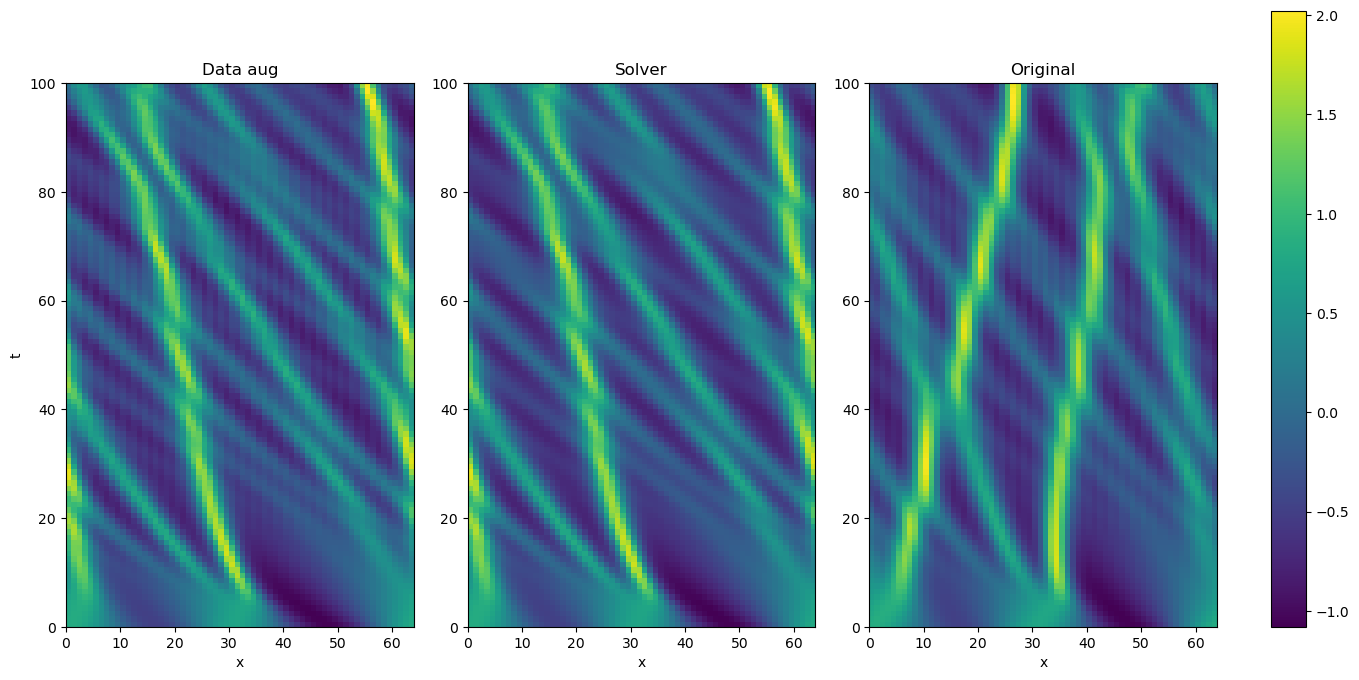

In [55]:
# Data aug via successive application of Lie point generators
plt.set_cmap('viridis')
sample  = (torch.tensor(sol_example.y.T), X)
# sol1 = SpaceTranslate(max_x_shift=1)(sample=sample, shift='fourier')
sol1 = sample
# sol2 = Scale(max_scale=0.25)(sample=sol1)
sol3 = Galileo(max_velocity=1)(sample=sol1, shift='fourier')

# sol3 = Galileo(max_velocity=1)(sample=sol2, shift='fourier')
# soln, Xn = sol3[0].numpy(), sol3[1].numpy()
# soln, Xn = sol2[0].numpy(), sol2[1].numpy()
soln, Xn = sol3[0].numpy(), sol3[1].numpy()


# Compute the solution using numerical solvers
# The initial condition is the first timestep of the augmented trajectory soln[0, :]
N = Xn.shape[-2]
Xmax = (Xn[0, -1, 0] - Xn[0, 0, 0]) * (N+1) / N
Tmax = Xn[-1, 0, 1] - Xn[0, 0, 1]
t = np.linspace(0, Tmax, soln.shape[0])
sol_crosscheck = solve_ivp(kdv_pseudospectral, [t[0], t[-1]], soln[0, :], method='Radau', t_eval=t, args=(Xmax,), atol=tol, rtol=tol)

# Calulate the normalized mse between augmented and crosscheck trajectory
mse = np.mean((sol_crosscheck.y.T - soln)**2)
normed_mse = mse / np.mean(sol_crosscheck.y.T**2)
root_normed_mse = np.sqrt(normed_mse)
print(f'Root normalized mean squared error: {root_normed_mse}')

gridspec = {'width_ratios': [1, 1, 1, 0.1]}
fig, axes = plt.subplots(1, 4, figsize=(16,8), gridspec_kw=gridspec)
# plt.subplot(131)
# 
axes[0].imshow(soln[::-1] , extent=[0,Xmax,0,Tmax])
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Data aug')
# plt.colorbar()

# axes[0].imshow(soln[::-1]) #, extent=[0,Xmax,0,Tmax])
# axes[0].set_xlabel('x')
# axes[0].set_ylabel('t')
# axes[0].set_title('Data aug')
# plt.colorbar()
# 
# plt.subplot(132)
# plt.imshow(sol_crosscheck.y.T[::-1]) #, extent=[0,Xmax,0,Tmax])
# plt.colorbar()

axes[1].set_title('Solver')
axes[1].imshow(sol_crosscheck.y.T[::-1], extent=[0,Xmax,0,Tmax]) #, extent=[0,Xmax,0,Tmax])
axes[1].set_xlabel('x')

# plt.subplot(133)
# plt.imshow(sol_example.y.T[::-1]) #, extent=[0,Xmax,0,Tmax])

# plt.colorbar()
axes[2].set_title('Original')
im2 = axes[2].imshow(sol_example.y.T[::-1] , extent=[0,Xmax,0,Tmax])
axes[2].set_xlabel('x')
# plt.colorbar()


for ax in axes:
    ax.set_anchor('S')
cax = axes[-1]
plt.colorbar(im2, cax=cax, cmap=plt.cm.get_cmap('plasma'))

plt.show()

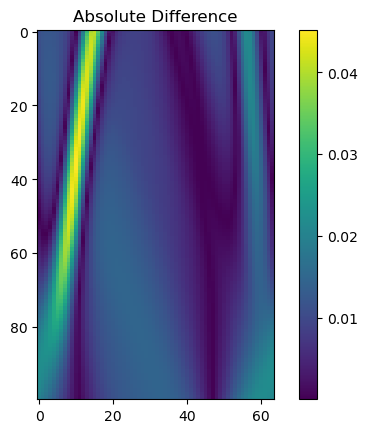

In [43]:
plt.imshow(np.abs(soln[::-1] - sol_example.y.T[::-1]))
plt.title("Absolute Difference")
plt.colorbar()